![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Reccomendation Building of Beer Reviews**

In [1]:
sc.defaultParallelism

1

### **Preliminaries**
#### We read in the allBeer.txt file and create an RDD consisting of lines.
#### We want to remove the header from the file, so the parseDataFileLine function identifies lines starting with 'beer_id' and applies a flag of 0, other lines with the correct number of fields are flagged 1, and incorrect lines are flagged -1.  The lines are split into arrays.

In [2]:
import re

def parseDatafileLine(datafileLine):
    ##Parse a line of the data file using the specified regular expression pattern
    splitArray = datafileLine.split("\t")
    for x in range(0,len(splitArray)):
        splitArray[x]=splitArray[x].replace("\"",'')
    #print len(splitArray)
    #print splitArray[0],
    splitArray[1],splitArray[2]
    if splitArray[0]=='beer_id':
        return (splitArray,0)
    elif len(splitArray)<>23:
        ##this is a failed parse
        return (splitArray,-1)
    else:
        return (splitArray, 1)

### Reading the file
#### We read the file into three rdds by first parsing the file as above, the header rdd, failed rdd and the valid rdd.  Print the header names so we can remember what fields we're dealing with and in what order.

In [3]:
import sys
import os

baseDir = os.path.join('')
allBeer_Path = 'AllBeer.txt'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    #Parse a data file returns a RDD of parsed lines
    
    return (sc
            .textFile(filename, 1, True)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    ##Load a data file, returns a RDD of parsed valid lines
    
    filename = os.path.join(baseDir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    header = (raw
              .filter(lambda s: s[1]==0)
             .map(lambda s:s[0])
             )
    headerDict={}
    for line in header.take(1):
        for x in range(0,len(line)):
            headerDict[x]=line[x]
            print x,line[x]
            
    rawLines = raw.count()
    validLines = valid.count()
    failedLines = failed.count()
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path, rawLines, validLines,failedLines)
    return valid, headerDict
    
allBeer,headers = loadData(allBeer_Path)
#allReviews = loadData(allReviews_Path)

0 beer_id
1 beer_name
2 brewer_name
3 beer_style
4 distribution
5 brewery_location
6 commercial_desc
7 RATINGS: 
8 MEAN (/5)
9 WEIGHTED AVG
10 EST. CALORIES
11 ABV (%)
12 IBU
13 SCORE
14 AROMA (/10)
15 APPEARANCE(/5)
16 TASTE(/10)
17 PALATE(/5)
18 OVERALL(/20)
19 reviewer_name
20 review_location
21 review_date
22 review_content
AllBeer.txt - Read 620388 lines, successfully parsed 620387 lines, failed to parse 0 lines


### Clean the Data
#### Since we're heavily dependent on the number of reviews each individual gives we will need to remove users who have an unacceptably low number, since we're dividing into training and test sets and the goal is to predict an order we should have at least 3 beers per user in the test set.  If we split 80/20 this means at least 12 beer reviews overall.  We are also going to immediately purge any blank reviews.

In [4]:
##Purge blank reviews and make (k,V) pairs
nonEmpty = allBeer.map(lambda x:(x[19],x)).filter(lambda (x,y):y[22]!='')
##Convert strings to floats for 13 through 18
def convertStrings(inputList,indexList):
    outList = []
    for x in range(0,len(inputList)):
        if x in indexList:
            outList.append(float(inputList[x]))
        else:
            outList.append(inputList[x])
    return outList
convIndicies=[13,14,15,16,17,18]
convertedToFloats = nonEmpty.map(lambda (x,y):(x,convertStrings(y,convIndicies)))

##Remove users with less than 12 reviews.
def removeUsers(inputRDD,minReviews):
    countPerUser = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    outRDD = inputRDD.join(countPerUser).filter(lambda (x,(y,z)):z>=minReviews)
    return outRDD.map(lambda (x,(y,z)):(x,y))

##Remove users not in Ontario.
def filterByLocation(inputRDD,location):
    outRDD = inputRDD.filter(lambda (x,y):y[20].lower().find(location)!=-1)
    return outRDD

beerByUser = removeUsers(convertedToFloats,40).cache()
print "There are %d users in the dataset." % beerByUser.map(lambda (x,y):x).distinct().count()
print "There are %d beers in the dataset." % beerByUser.map(lambda (x,y):y[0]).distinct().count()
print "There are %d reviews in the dataset." % beerByUser.count()

There are 2276 users in the dataset.
There are 99193 beers in the dataset.
There are 553283 reviews in the dataset.


In [5]:
##Don't Normalize the scores
beerNormalized = beerByUser

### Now we'll split the data into a training set (80%),  test set (20%) 
#### This is slightly complicated by the fact that we want to split each user into 80/20, not the set of reviews as a whole.  We will take advantage of stratified sampling in Spark, grouping the reviews by the user name, then sampling by key.  To get the unused data we employ subtractByKey using a compound key of the username and the beer_id, guaranting uniqueness.

In [6]:
##Using the allBeer array, take stratified sample, and remove blank reviews.
sampleKeys = beerNormalized.keys().collect()
fractions={}
for k in sampleKeys:
    fractions[k]=0.8
    
beerTrain = beerNormalized.sampleByKey(False,fractions).cache()
beerTrainKeyed = beerTrain.map(lambda (x,y):(y[0]+y[19],y))
beerTest = beerNormalized.map(lambda (x,y):(y[0]+y[19],y)).subtractByKey(beerTrainKeyed).map(lambda (x,y):(y[19],y)).cache()
#beerTestAndVal = beerNormalized.map(lambda (x,y):(y[0]+y[19],y)).subtractByKey(beerTrainKeyed)
#sampleKeys = beerTestAndVal.keys().collect()
#fractions={}
#for k in sampleKeys:
#    fractions[k]=0.5
#beerTestCombinedKey = beerTestAndVal.sampleByKey(False,fractions)
#beerTest = beerTestCombinedKey.map(lambda (x,y):(y[19],y)).cache()
#beerVal = beerTestAndVal.subtractByKey(beerTestCombinedKey).map(lambda (x,y):(y[19],y)).cache()
bNC = beerNormalized.count()
bTrC = float(beerTrain.count())
bTeC = float(beerTest.count() )
#bVC = float(beerVal.count())
print "Total reviews: %f" % float(bNC)
print "Training set: %f  Percentage: %f" %(bTrC,bTrC/bNC)
print "Test set: %f  Percentage: %f" %(bTeC,bTeC/bNC)
#print "Validation set: %f  Percentage: %f" %(bVC,bVC/bNC)

Total reviews: 553283.000000
Training set: 442751.000000  Percentage: 0.800225
Test set: 110532.000000  Percentage: 0.199775


### Spearman Correlation
#### Let's implement a Spearman Rank Function so we can have a metric to compare the order of two lists.
#### I wrote this because the internal spearman correlation in scipy is bugged, a known issue and hasn't yet been fixed as of Spark 1.5.2

In [7]:
### ToDo: lookup Kendall Tau, Rank Biased Overlap (RBO), maybe mean squared error??
from scipy.stats import spearmanr
from scipy.stats.stats import rankdata
from scipy.stats import pearsonr
import math

### Need to implement a function which will take the results from the cosSim RDD and spit out
### average?? spearman.

def catTuplesToLists(tupleOne,tupleTwo):
    if len(tupleOne)==len(tupleTwo):
        a=[]
        for x in range(0,len(tupleOne)):
            firstEle=tupleOne[x]
            if type(firstEle) is not list: firstEle = [ tupleOne[x] ]
            secondEle=tupleTwo[x]
            if type(secondEle) is not list: secondEle = [ tupleTwo[x] ]
            a.append(firstEle+secondEle)
        return tuple(a)
    else:
        raise ValueError('Two tuples are not the same dimensions')

def mattSpearman(listOne,listTwo):
    if type(listOne) is list and type(listTwo) is list:
        lO=len(listOne)
        if lO==len(listTwo) and lO>1:
            lOR = rankdata(listOne)
            lTR = rankdata(listTwo)
            print lOR
            print lTR
            dSquared=0
            for x in range(0,lO):
                dSquared+=(lOR[x]-lTR[x])**2
            return 1-6*dSquared/lO/(lO**2-1)
        else:
            raise ValueError("Both Lists must be same length and greater than one.")
    else:
        return 0

def reduceNaN(a,b):
    if math.isnan(a):
        a=0
    if math.isnan(b):
        b=0
    return a+b

def avgSpearman(inputRDD):
    #So the problem here is trying to output two lists which have the scores in the same order.
    #Write custom reduce function, catTuplesToLists
    convertedToLists = inputRDD.reduceByKey(catTuplesToLists)
    #print convertedToLists.take(5)
    filteredLists = convertedToLists.filter(lambda (x,y):type(y[1]) is list)
    #print filteredLists.take(5)
    spearmanByKey = filteredLists.map(lambda (x,y):(x,mattSpearman(y[1],y[2]), len(y[1])))
    #print spearmanByKey.take(5)
    spearmanOnly = spearmanByKey.map(lambda (x,y,z):y)
    #print spearmanOnly.count()
    #print spearmanOnly.take(5)
    avgSpearmanRho=spearmanOnly.reduce(lambda a,b:a+b)/spearmanOnly.count()
    return avgSpearmanRho

def maxNPerKey(inputRDD,N):
    ##Take a random N lines per Key, return RDD with N or less entries in each key.
    entriesPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b).collect()
    fractions={}
    for k in entriesPerKey:
        if k[1]<=N:
            fractions[k[0]]=1
        else:
            fractions[k[0]]=N/k[1]
    return inputRDD.sampleByKey(False,fractions)
    

In [8]:
##First need to make integer usernames since ALS doesn't support text userIDs.
##Solution: create a dictionary
#print beerTrain.take(5)
import unicodedata
import MySQLdb
def getUsersFromDatabase():
    userDictionary={}
    mydb = MySQLdb.connect(host='localhost',
        user='pythonconnector',
        passwd='python1029',
        db='BeerRatings')
    cursor = mydb.cursor()
    cursor.execute("SELECT * FROM users")
    queryResults = cursor.fetchall()
    cursor.close()
    mydb.close()
    for result in queryResults:
        userDictionary[result[1].decode('utf-8')]=result[0]
    return userDictionary

userDict = getUsersFromDatabase()
print userDict.keys()[0:5]

[u'nazzty', u'Manetsdad', u'Bewitched', u'Nejhleader', u'CObiased']


## Make a Naive Bayes Classifier For Each User
### Step 1: Making Bags of Words
#### We can take the commercial descriptions and the user input text reviews and convert them into bags of words, we can then treat each word as a feature.  
#### We should take out stopwords before we do this, to avoid unfairly weighting reviews based on words which don't contribute much meaning, such as "the", "a", "is", "which", etc.

In [9]:
stopfile = os.path.join(baseDir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
testString = "This is a test of the tf function.  It should return non stopword frequencies frequency sourness"
print 'These are the stopwords: %s' % stopwords
split_regex = r'\W+'

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def tokenize(string):
    ##takes in a string and tokenizes it, removing stopwords, returns list
    simple=filter(None,re.split(split_regex,string.lower()))
    simple = [wnl.lemmatize(i) for i in simple]
    return [i for i in simple if i not in stopwords]

print tokenize(testString)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

In [10]:
##6 commercial description
##22 user input review
##make an RDD where the user_id is the key, and the value is 2 arrays of tokens 
##and the original line
def checkEmpty(inputList):
    if not inputList:
        return False
    else:
        return True
    
beerTrainToToken = beerTrain.map(lambda (x,y):(y[19],(tokenize(y[6]),tokenize(y[22]),y))).filter(lambda (x,(a,b,c)):checkEmpty(c))

def countTokens(textRDD,reviewTRUE):
    ## Count and return the number of tokens
    if reviewTRUE==True:
        return textRDD.map(lambda (x,y):len(y[1])).reduce(lambda a,b:a+b)
    else:
        return textRDD.map(lambda (x,y):len(y[0])).reduce(lambda a,b:a+b)

print 'There are %s tokens in the commercial descriptions' % countTokens(beerTrainToToken,False)
print 'There are %s tokens in the reviews' % countTokens(beerTrainToToken,True)

There are 10280104 tokens in the commercial descriptions
There are 14854780 tokens in the reviews


### Naive Bayes
#### Now it gets a little tricky, we want to predict the score a specific user will give to a beer based on the words in the reviews.  We will need to train a Naive Bayes classifier for each user, then apply it to the test reviews.  Also since we're using so many classes, it's not very informative to pick just the highest probability class, in the nltk naive bayes classifier there is a method to return the probability distribution of all classes, which we can then multiply by the score to get the expectation value of the user's score.

### First load up the features from the previous analysis.

In [11]:
featuresFileName = os.path.join(baseDir, "sortedFeatures.txt")
def parseFeatFile(inputLine):
    word,wscore=inputLine.split(",")
    return word,wscore
features = sc.textFile(featuresFileName, 1).map(parseFeatFile).cache()
featureList = features.map(lambda (x,y):x).collect()
x = 400
featTopX = featureList[:x]+featureList[-x:]
print featTopX[:20]
print featTopX[-20:]

[u'corn', u'watery', u'water', u'lager', u'bad', u'metallic', u'bland', u'cardboard', u'infected', u'stale', u'weak', u'grainy', u'pale', u'flat', u'grain', u'thin', u'artificial', u'yellow', u'cheap', u'terrible']
[u'barrel', u'brandy', u'thick', u'roasted', u'dark', u'cherry', u'complex', u'full', u'grapefruit', u'balanced', u'coconut', u'smooth', u'oak', u'tropical', u'black', u'rich', u'vanilla', u'coffee', u'chocolate', u'bourbon']


### Now make dictionaries for each beer

In [12]:
from nltk.classify import NaiveBayesClassifier

def generateDict(bagOfWords,allowedWords):
    outDict={}
    for word in allowedWords:
        outDict[word]=0
    for word in bagOfWords:
        if word in outDict:
            outDict[word]+=1
    return outDict
            
allWordsPerBeer = beerTrainToToken.map(lambda (x,(a,b,c)): (c[0],b)).reduceByKey(lambda a,b:a+b)
dictPerBeer = allWordsPerBeer.map(lambda (x,a):(x,generateDict(a,featTopX)))
print dictPerBeer.takeSample(False,3,1)

[(u'49211', {u'yellow': 1, u'graininess': 0, u'mild': 1, u'salted': 0, u'skin': 0, u'dish': 0, u'woody': 3, u'guava': 0, u'milk': 0, u'poorly': 0, u'liquorice': 0, u'varnish': 0, u'yummy': 0, u'peanut': 0, u'stinky': 0, u'bile': 0, u'sparkling': 0, u'veg': 0, u'compost': 0, u'melon': 0, u'brown': 6, u'overwhelmed': 0, u'vinegary': 0, u'mainstream': 0, u'dessert': 0, u'blanket': 0, u'brownie': 0, u'balancing': 0, u'bleach': 0, u'anemic': 0, u'school': 0, u'heaven': 0, u'washing': 0, u'salad': 0, u'level': 0, u'cooky': 0, u'lawnmower': 0, u'watered': 0, u'frozen': 0, u'small': 0, u'nondescript': 0, u'round': 0, u'farmhouse': 0, u'dilute': 0, u'miller': 0, u'parmesan': 0, u'radler': 0, u'kolsch': 0, u'nail': 0, u'dishwater': 0, u'second': 0, u'currant': 0, u'dried': 2, u'subtle': 0, u'copenhagen': 0, u'shandy': 0, u'port': 0, u'windex': 0, u'soured': 0, u'bomber': 0, u'hide': 0, u'peel': 0, u'opaque': 2, u'espresso': 1, u'musty': 0, u'sweaty': 0, u'oaky': 2, u'rotten': 0, u'abv': 0, u'sha

In [13]:
##join user and rating to beer and dictionary, map to user,(dictionary,rating)
ratingAndDictPerUser = beerTrainToToken.map(lambda (x,(a,b,c)):(c[0],(x,c[13]))).join(dictPerBeer).map(lambda (x,((a,b),c)):(a,[(c,b)]))
##test to see if the format is good.
ratingAndDictListPerUser = ratingAndDictPerUser.reduceByKey(lambda a,b:a+b)
#print ratingAndDictListPerUser.takeSample(False,2,1)
#ratingAndDictListPerUser.take(1)
#classifier = NaiveBayesClassifier.train(trainfeatsAndClasses)

In [14]:
classifierRDD = ratingAndDictListPerUser.map(lambda (x,y):(x,NaiveBayesClassifier.train(y)))

In [15]:
testBeersWithUserAndScore = beerTest.map(lambda (a,b): (b[0],(a,b[13],b[1])))
###map to user,(score,beername,dict)
testBeersWithDicts = testBeersWithUserAndScore.join(dictPerBeer).map(lambda (a,((b,c,d),e)):(b,(c,a,e)))
#print testBeersWithDicts.takeSample(False,1,1)

In [16]:
def expectationValue(classifier,inputDict):
    probSample = classifier.prob_classify(inputDict)
    sumProb=0
    for sample in probSample.samples():
        sumProb+=float(sample)*probSample.prob(sample)
    return sumProb

ratesAndPredsClassifier = classifierRDD.join(testBeersWithDicts).map(lambda (x,(a,(b,c,d))):(x,(c,b,expectationValue(a,d))))
##Now test MSE and spearman
MSE = ratesAndPredsClassifier.map(lambda (x,(a,b,c)):(b-c)**2).mean()
print MSE
print "The Spearman correlation using individual Naive Bayes classifiers is %f" % avgSpearman(ratesAndPredsClassifier)


0.276885900502
The Spearman correlation using individual Naive Bayes classifiers is 0.176307


In [18]:
ratingsXpredictionY = ratesAndPredsClassifier.map(lambda (x,(a,b,c)): (b,c)).collect()

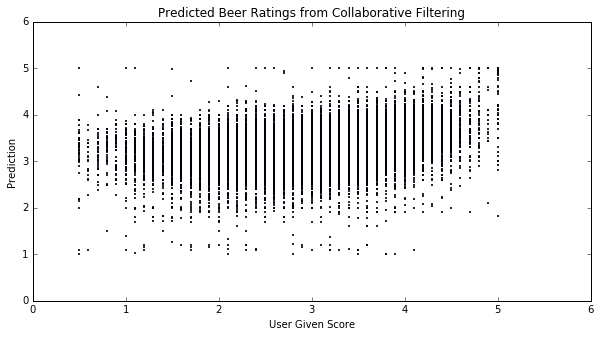

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
ratingsX=[x[0] for x in ratingsXpredictionY]
predictionY=[x[1] for x in ratingsXpredictionY]
fig = plt.figure(figsize=(10,5))
plt.title("Predicted Beer Ratings from Collaborative Filtering")
plt.scatter(ratingsX,predictionY,s=1)
plt.xlabel("User Given Score")
plt.ylabel("Prediction")
plt.xlim([0,6])
plt.show()
pass